In [1]:
import re
import contractions
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from nltk.corpus import wordnet
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder, TrigramCollocationFinder

In [2]:
from nltk.corpus import stopwords
nltk.download('stopwords')  # Download the stopword corpus
stop_words = set(stopwords.words('english'))  # Get English stop words

[nltk_data] Downloading package stopwords to /Users/bobli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the Dataset

In [3]:
# load the main datasets
df1 = pd.read_csv('cleaned_hm.csv')
df2 = pd.read_csv('original_hm.csv')
df3 = pd.read_csv('demographic.csv')
df4 = pd.read_csv('vad.csv')
df5 = pd.read_csv('senselabel.csv')

In [4]:
# load topic datasets
exercise = pd.read_csv('exercise-dict.csv')
family = pd.read_csv('family-dict.csv')
food = pd.read_csv('food-dict.csv')
people = pd.read_csv('people-dict.csv')
pets = pd.read_csv('pets-dict.csv')
school = pd.read_csv('school-dict.csv')
shopping = pd.read_csv('shopping-dict.csv')
work = pd.read_csv('work-dict.csv')
entertainment = pd.read_csv('entertainment-dict.csv')

# Data Cleaning and Preprocessing

In [5]:
# Clean df3 demographics
# remove wrong and outlier values in the age column
# contains only the 20-40 year old people
def clean_age(age):
    try:
        # Convert to float and then to int to remove decimals
        age = int(float(age))
    except ValueError:
        # If conversion fails, return None
        return None

    # Return age if it's within a realistic range (20-40), else return None
    return age if 20 <= age <= 40 else None

# Apply the cleaning function to the Age column
df3['age'] = df3['age'].apply(clean_age)

# Remove rows with None in Age column
df3 = df3.dropna(subset=['age'])

In [6]:
# extract the rows with only USA nationality
df3_usa = df3[(df3['country'] == 'USA')]
df13 = pd.merge(df1,df3_usa)

# drop unnecessary columns
df13_drop = df13.drop(columns=['modified', 'num_sentence', 'ground_truth_category'])
df5_drop = df5.drop(columns=['supersenseLabel'])

In [11]:
# create two columns for each topic dataset
exercise['topic'] = 'exercise'
family['topic'] = 'family'
food['topic'] = 'food'
people['topic'] = 'people'
pets['topic'] = 'pets'
school['topic'] = 'school'
shopping['topic'] = 'shopping'
work['topic'] = 'work'
entertainment['topic'] = 'entertainment'
exercise.columns = ['word', 'topic']
family.columns = ['word', 'topic']
food.columns = ['word', 'topic']
people.columns = ['word', 'topic']
pets.columns = ['word', 'topic']
school.columns = ['word', 'topic']
shopping.columns = ['word', 'topic']
work.columns = ['word', 'topic']
entertainment.columns = ['word', 'topic']
dfs = [exercise, family, food, people, pets, school, shopping, work, entertainment]
total_topics = pd.concat(dfs, axis=0)
topics_dict = total_topics.set_index('word')['topic'].to_dict()

In [12]:
# merge cleaned_hm, demographics, and senselabel
df135 = pd.merge(df13_drop,df5_drop)
df1345 = pd.merge(df135, df4)

# remove stop words
token_df = df1345
token_df = token_df[~token_df['word'].isin(stop_words)]
token_df = token_df.copy()
token_df['topic'] = token_df['word'].map(topics_dict)

token_df[["hmid","wid",'word','lowercaseLemma']] = token_df[["hmid","wid",'word','lowercaseLemma']].astype(str)
token_df['matched_topic'] = None

# Function to remove stopwords and punctuation
def remove_stopwords_punctuation(text):
    # Remove punctuation
    no_punct = "".join([char for char in text if char not in string.punctuation])
    # Remove stopwords
    return " ".join([word for word in no_punct.split() if word.lower() not in stop_words])

# Apply the function to your column
token_df['word'] = token_df['word'].apply(remove_stopwords_punctuation)

In [13]:
# split df13 into male and female group
total_male = token_df[token_df['gender'] == 'm']
total_female = token_df[token_df['gender'] == 'f']

# split the dataset by marital status
total_single = token_df[token_df['marital'] == 'single']
total_married = token_df[token_df['marital'] == 'married']

# split the dataset by time span
total_24h = token_df[token_df['reflection_period']=='24h']
total_3m = token_df[token_df['reflection_period']=='3m']

# split the dataset by gender and marital status
male_single = token_df[(token_df['gender'] == 'm') & (token_df['marital'] == 'single')]
male_married = token_df[(token_df['gender'] == 'm') & (token_df['marital'] == 'married')]
female_single = token_df[(token_df['gender'] == 'f') & (token_df['marital'] == 'single')]
female_married = token_df[(token_df['gender'] == 'f') & (token_df['marital'] == 'married')]
# split by gender and time span
male_24h = total_male[total_male['reflection_period']=='24h']
male_3m = total_male[total_male['reflection_period']=='3m']
female_24h = total_female[total_female['reflection_period']=='24h']
female_3m = total_female[total_female['reflection_period']=='3m']

# split the two marital groups by time span
single_24h = total_single[total_single['reflection_period']=='24h']
single_3m = total_single[total_single['reflection_period']=='3m']
married_24h = total_married[total_married['reflection_period']=='24h']
married_3m = total_married[total_married['reflection_period']=='3m']

## split by gender, martial staus, and time span
male_single_24h = male_single[(male_single['reflection_period']=='24h')]
male_single_3m = male_single[(male_single['reflection_period']=='3m')]
male_married_24h = male_married[(male_married['reflection_period']=='24h')]
male_married_3m = male_married[(male_married['reflection_period']=='3m')]

female_single_24h = female_single[(female_single['reflection_period']=='24h')]
female_single_3m = female_single[(female_single['reflection_period']=='3m')]
female_married_24h = female_married[(female_married['reflection_period']=='24h')]
female_married_3m = female_married[(female_married['reflection_period']=='3m')]

# split the dataset by topic
exercise_df = token_df[token_df['topic']=='exercise']
family_df = token_df[token_df['topic']=='family']
food_df = token_df[token_df['topic']=='food']
people_df = token_df[token_df['topic']=='people']
pets_df = token_df[token_df['topic']=='pets']
school_df = token_df[token_df['topic']=='school']
shopping_df = token_df[token_df['topic']=='shopping']
work_df = token_df[token_df['topic']=='work']
entertainment_df = token_df[token_df['topic']=='entertainment']

In [14]:
# split the dataset by category
affection_cat = token_df[token_df['predicted_category']=='affection']
achievement_cat = token_df[token_df['predicted_category']=='achievement']
moment_cat = token_df[token_df['predicted_category']=='enjoy_the_moment']
bonding_cat = token_df[token_df['predicted_category']=='bonding']
leisure_cat = token_df[token_df['predicted_category']=='leisure']
nature_cat = token_df[token_df['predicted_category']=='nature']
exercise_cat = token_df[token_df['predicted_category']=='exercise']

# split the dataset by category
male_affection_cat = token_df[(token_df['predicted_category']=='affection') & (token_df['gender'] == 'm')]
male_achievement_cat = token_df[(token_df['predicted_category']=='achievement')& (token_df['gender'] == 'm')]
male_moment_cat = token_df[(token_df['predicted_category']=='enjoy_the_moment')& (token_df['gender'] == 'm')]
male_bonding_cat = token_df[(token_df['predicted_category']=='bonding')& (token_df['gender'] == 'm')]
male_leisure_cat = token_df[(token_df['predicted_category']=='leisure')& (token_df['gender'] == 'm')]
male_nature_cat = token_df[(token_df['predicted_category']=='nature')& (token_df['gender'] == 'm')]
male_exercise_cat = token_df[(token_df['predicted_category']=='exercise')& (token_df['gender'] == 'm')]

# split the dataset by category
male_married_affection = male_affection_cat[(male_affection_cat['marital'] == 'married')]
male_married_achievement = male_achievement_cat[(male_achievement_cat['marital'] == 'married')]
male_married_moment = male_moment_cat[(male_moment_cat['marital'] == 'married')]
male_married_bonding = male_bonding_cat[(male_bonding_cat['marital'] == 'married')]
male_married_leisure = male_leisure_cat[(male_leisure_cat['marital'] == 'married')]
male_married_nature = male_nature_cat[(male_nature_cat['marital'] == 'married')]
male_married_exercise = male_exercise_cat[(male_exercise_cat['marital'] == 'married')]

# split the dataset by category
male_single_affection = male_affection_cat[(male_affection_cat['marital'] == 'single')]
male_single_achievement = male_achievement_cat[(male_achievement_cat['marital'] == 'single')]
male_single_moment = male_moment_cat[(male_moment_cat['marital'] == 'single')]
male_single_bonding = male_bonding_cat[(male_bonding_cat['marital'] == 'single')]
male_single_leisure = male_leisure_cat[(male_leisure_cat['marital'] == 'single')]
male_single_nature = male_nature_cat[(male_nature_cat['marital'] == 'single')]
male_single_exercise = male_exercise_cat[(male_exercise_cat['marital'] == 'single')]

In [15]:
# male,married, cat, 24h
mm_24h_affection = male_married_affection[(male_married_affection['reflection_period'] == '24h')]
mm_24h_achievement = male_married_achievement[(male_married_achievement['reflection_period'] == '24h')]
mm_24h_moment = male_married_moment[(male_married_moment['reflection_period'] == '24h')]
mm_24h_bonding = male_married_bonding[(male_married_bonding['reflection_period'] == '24h')]
mm_24h_leisure = male_married_leisure[(male_married_leisure['reflection_period'] == '24h')]
mm_24h_nature = male_married_nature[(male_married_nature['reflection_period'] == '24h')]
mm_24h_exercise = male_married_exercise[(male_married_exercise['reflection_period'] == '24h')]

# male, married, cat, 3m
mm_3m_affection = male_married_affection[(male_married_affection['reflection_period'] == '3m')]
mm_3m_achievement = male_married_achievement[(male_married_achievement['reflection_period'] == '3m')]
mm_3m_moment = male_married_moment[(male_married_moment['reflection_period'] == '3m')]
mm_3m_bonding = male_married_bonding[(male_married_bonding['reflection_period'] == '3m')]
mm_3m_leisure = male_married_leisure[(male_married_leisure['reflection_period'] == '3m')]
mm_3m_nature = male_married_nature[(male_married_nature['reflection_period'] == '3m')]
mm_3m_exercise = male_married_exercise[(male_married_exercise['reflection_period'] == '3m')]

mm_24h_achievement_work = mm_24h_achievement[(mm_24h_achievement['topic'] == 'work')]
mm_3m_achievement_work = mm_3m_achievement[(mm_3m_achievement['topic'] == 'work')]

# Analysis on Word Frequency in Work

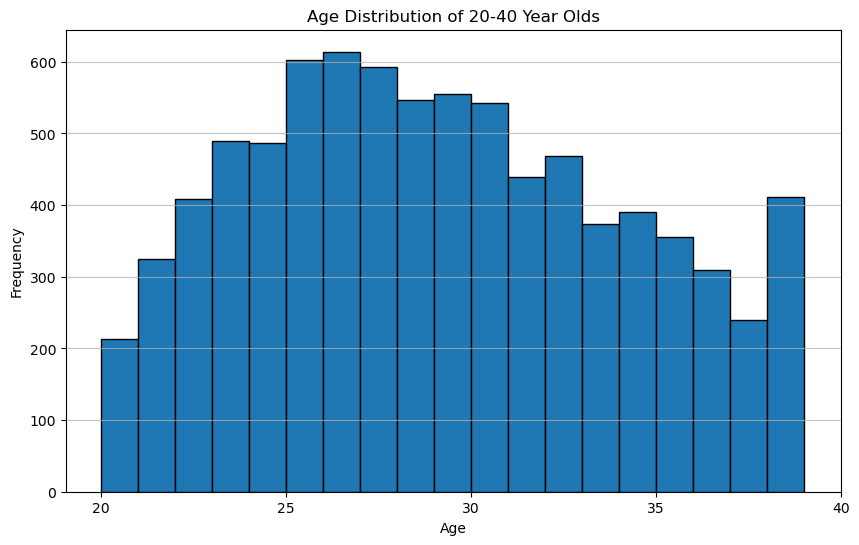

In [16]:
# Plotting the age distribution
plt.figure(figsize=(10, 6))
plt.hist(df3['age'], bins=range(20, 40), edgecolor='black')
plt.title('Age Distribution of 20-40 Year Olds')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xticks(range(20, 45, 5))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [17]:
# Filter sentences containing the word 'work'
sentences_with_work = male_married[male_married['cleaned_hm'].str.contains(' work ', case=False, na=False)]
three_sentences = sentences_with_work['cleaned_hm'].head(3)
sentences_with_work = sentences_with_work.copy()
sentences_with_work['cleaned_hm'] = sentences_with_work['cleaned_hm'].drop_duplicates()
sentences_with_work.dropna(subset=['cleaned_hm'], inplace=True)

In [18]:
print(sentences_with_work['cleaned_hm'][5689],
      '\n',sentences_with_work['cleaned_hm'][6370],
      '\n', sentences_with_work['cleaned_hm'][6644])

I received a bonus yesterday from my work here in mturk which is really nice. 
 I received an award for my work on a tough loan process that I helped develop. 
 I secured funding for a project at work that will boost loan sales by at least 60%


In [429]:
sentences_with_work = male_single[male_single['cleaned_hm'].str.contains(' work ', case=False, na=False)]
three_sentences = sentences_with_work['cleaned_hm'].head(3)
sentences_with_work = sentences_with_work.copy()
sentences_with_work['cleaned_hm'] = sentences_with_work['cleaned_hm'].drop_duplicates()
sentences_with_work.dropna(subset=['cleaned_hm'], inplace=True)

In [431]:
print(sentences_with_work['cleaned_hm'][624],
      '\n',sentences_with_work['cleaned_hm'][781],
      '\n', sentences_with_work['cleaned_hm'][1110])

Won a raffle at work for 6 months of Graze, and I love mystery boxes! 
 I got acknowledged by my manager for my hard work I've been putting in recently. 
 I got a compliment from my manager at work the other day.


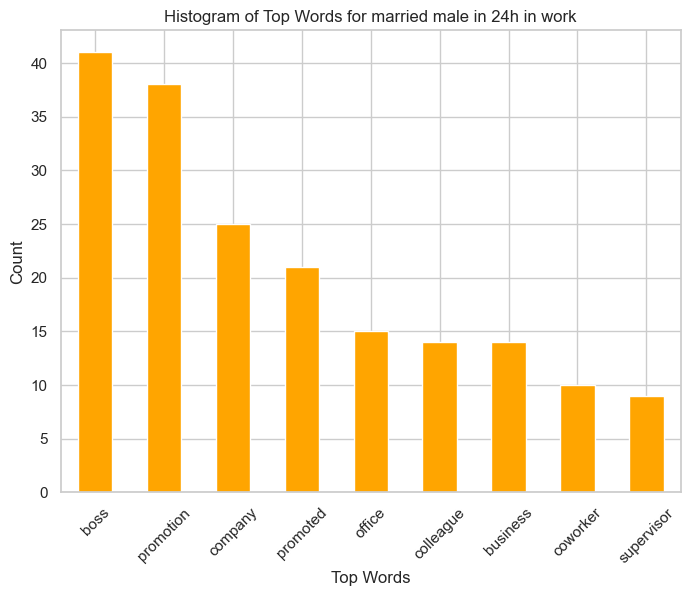

In [450]:
plt.figure(figsize=(8, 6))

# Calculate value counts and select top 10
top_words = mm_24h_achievement_work['word'].value_counts().nlargest(10)
top_words = top_words[1:]

# Plot the top 10 male counts
top_words.plot(kind='bar', color='orange')

plt.title(f'Histogram of Top Words for married male in 24h in work')
plt.xlabel('Top Words')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

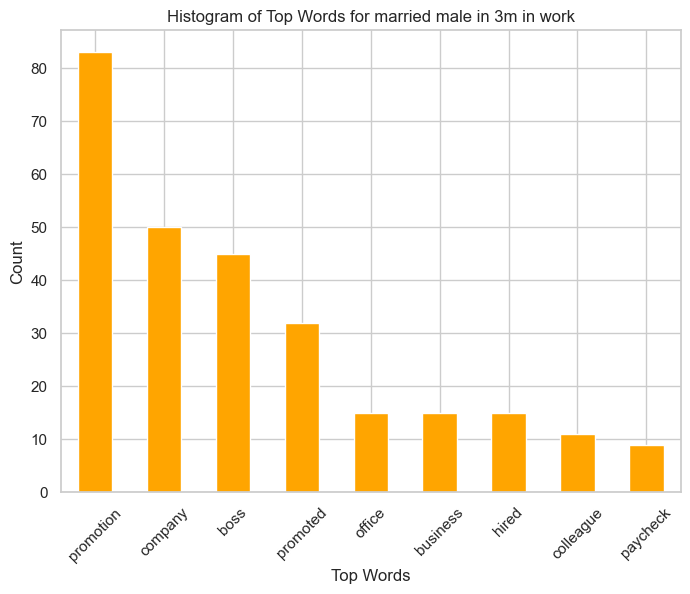

In [451]:
plt.figure(figsize=(8, 6))
top_words = mm_3m_achievement_work['word'].value_counts().nlargest(10)
top_words = top_words[1:]

# Plot the top 10 male counts
top_words.plot(kind='bar', color='orange')

plt.title(f'Histogram of Top Words for married male in 3m in work')
plt.xlabel('Top Words')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

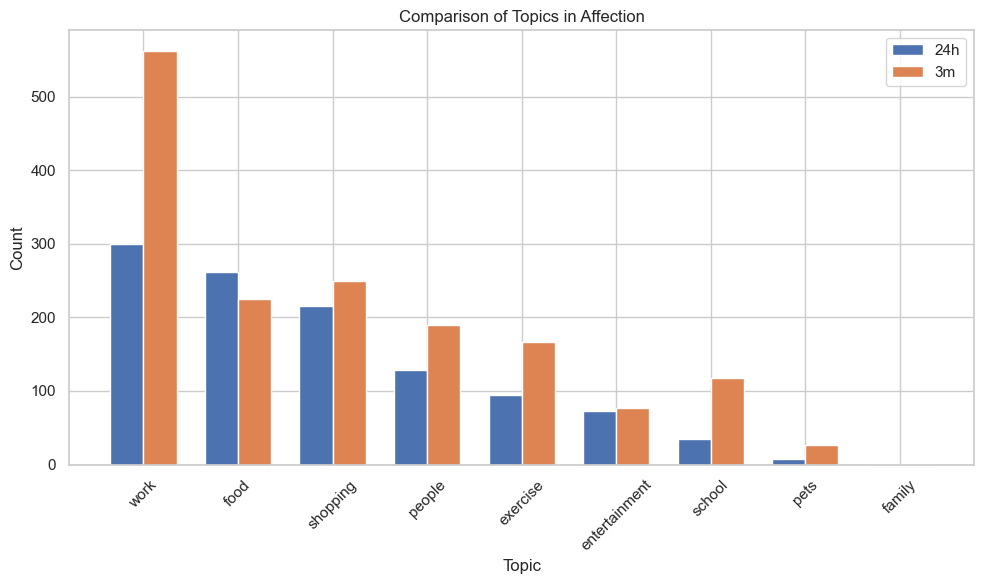

In [453]:
# Step 1: Prepare the Data
counts_24h = mm_24h_achievement['topic'].value_counts().rename('24h')
counts_3m = mm_3m_achievement['topic'].value_counts().rename('3m')

# Step 2: Merge the DataFrames
combined = pd.concat([counts_24h, counts_3m], axis=1).fillna(0)

plt.figure(figsize=(10, 6))
x = np.arange(len(combined))
width = 0.35

plt.bar(x - width/2, combined['24h'], width, label='24h')
plt.bar(x + width/2, combined['3m'], width, label='3m')

# Add some text for labels, title and custom x-axis tick labels
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Comparison of Topics in Affection')
plt.xticks(x, combined.index, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Analysis of Topic Frequency in Each Category

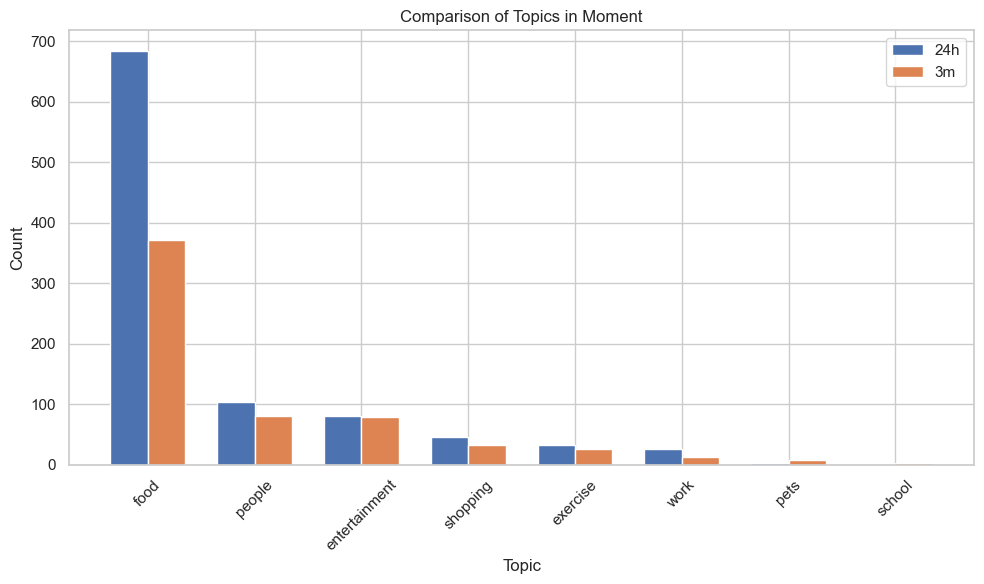

In [454]:
# Step 1: Prepare the Data
counts_24h = mm_24h_moment['topic'].value_counts().rename('24h')
counts_3m = mm_3m_moment['topic'].value_counts().rename('3m')

# Step 2: Merge the DataFrames
combined = pd.concat([counts_24h, counts_3m], axis=1).fillna(0)

# Step 3: Plot the Dual Bar Chart
plt.figure(figsize=(10, 6))
x = np.arange(len(combined))
width = 0.35  # the width of the bars

plt.bar(x - width/2, combined['24h'], width, label='24h')
plt.bar(x + width/2, combined['3m'], width, label='3m')

# Add some text for labels, title and custom x-axis tick labels
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Comparison of Topics in Moment')
plt.xticks(x, combined.index, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

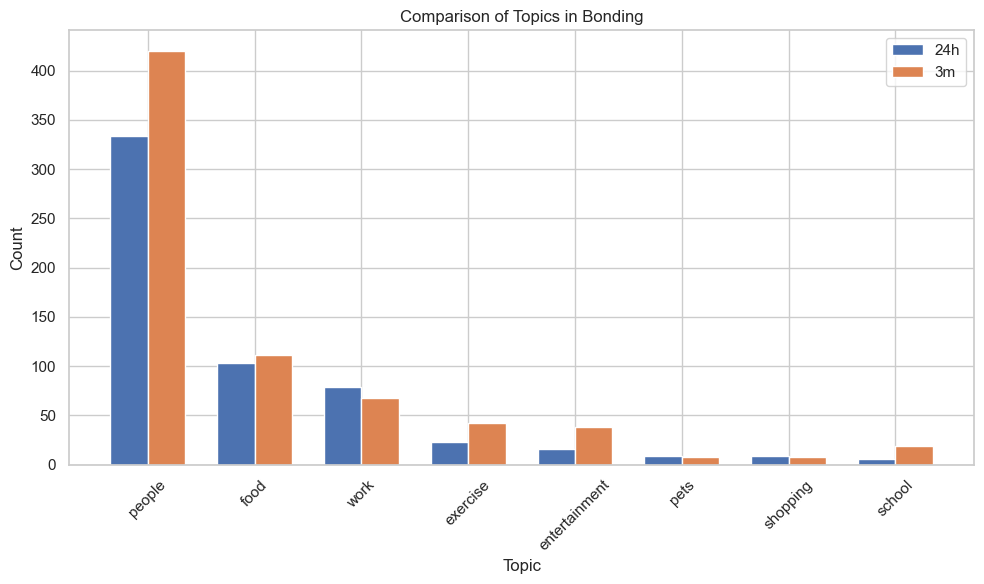

In [455]:
# Step 1: Prepare the Data
counts_24h = mm_24h_bonding['topic'].value_counts().rename('24h')
counts_3m = mm_3m_bonding['topic'].value_counts().rename('3m')

# Step 2: Merge the DataFrames
combined = pd.concat([counts_24h, counts_3m], axis=1).fillna(0)

# Step 3: Plot the Dual Bar Chart
plt.figure(figsize=(10, 6))
x = np.arange(len(combined))
width = 0.35  # the width of the bars

plt.bar(x - width/2, combined['24h'], width, label='24h')
plt.bar(x + width/2, combined['3m'], width, label='3m')

# Add some text for labels, title and custom x-axis tick labels
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Comparison of Topics in Bonding')
plt.xticks(x, combined.index, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
mm_24h_achievement_work = mm_24h_achievement[(mm_24h_achievement['topic'] == 'work')]

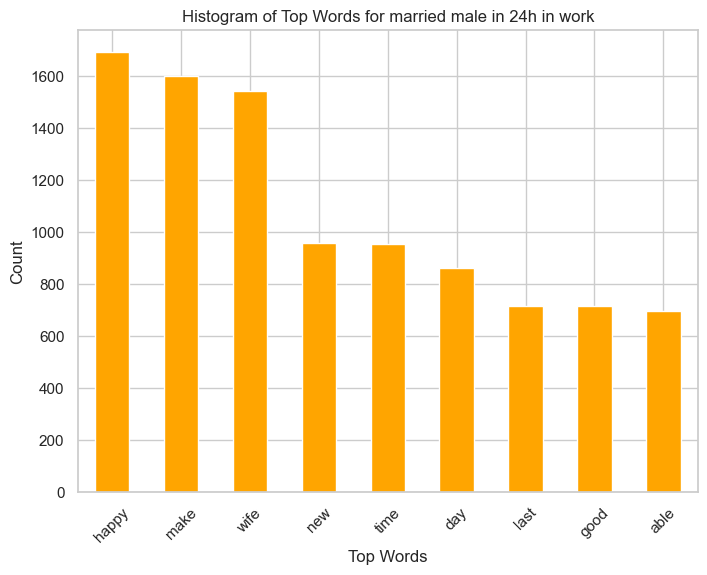

In [491]:
plt.figure(figsize=(8, 6))

# Calculate value counts and select top 10
top_words = male_married_test['lowercaseLemma'].value_counts().nlargest(10)
top_words = top_words[1:]

# Plot the top 10 male counts
top_words.plot(kind='bar', color='orange')

plt.title(f'Histogram of Top Words for married male in 24h in work')
plt.xlabel('Top Words')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

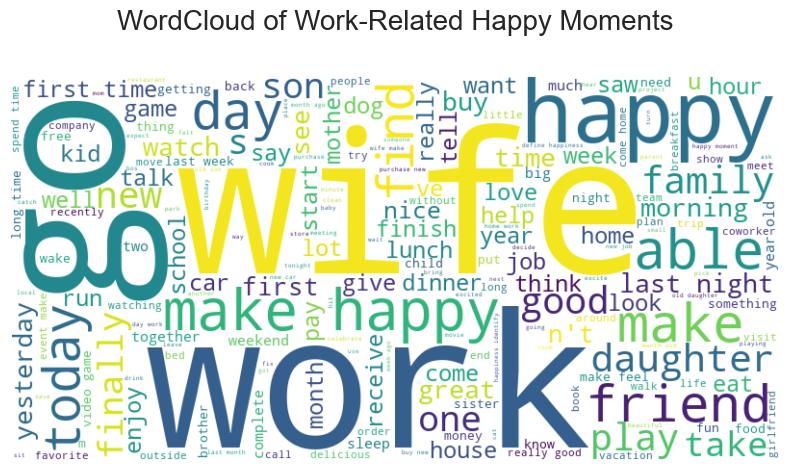

In [473]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

work_tokens = [token_list for token_list in male_married["lowercaseLemma"]]

# Join the words into a single string
wordcloud_text = " ".join(work_tokens)

# Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Work-Related Happy Moments', fontsize=20, y=1.1)
plt.show()

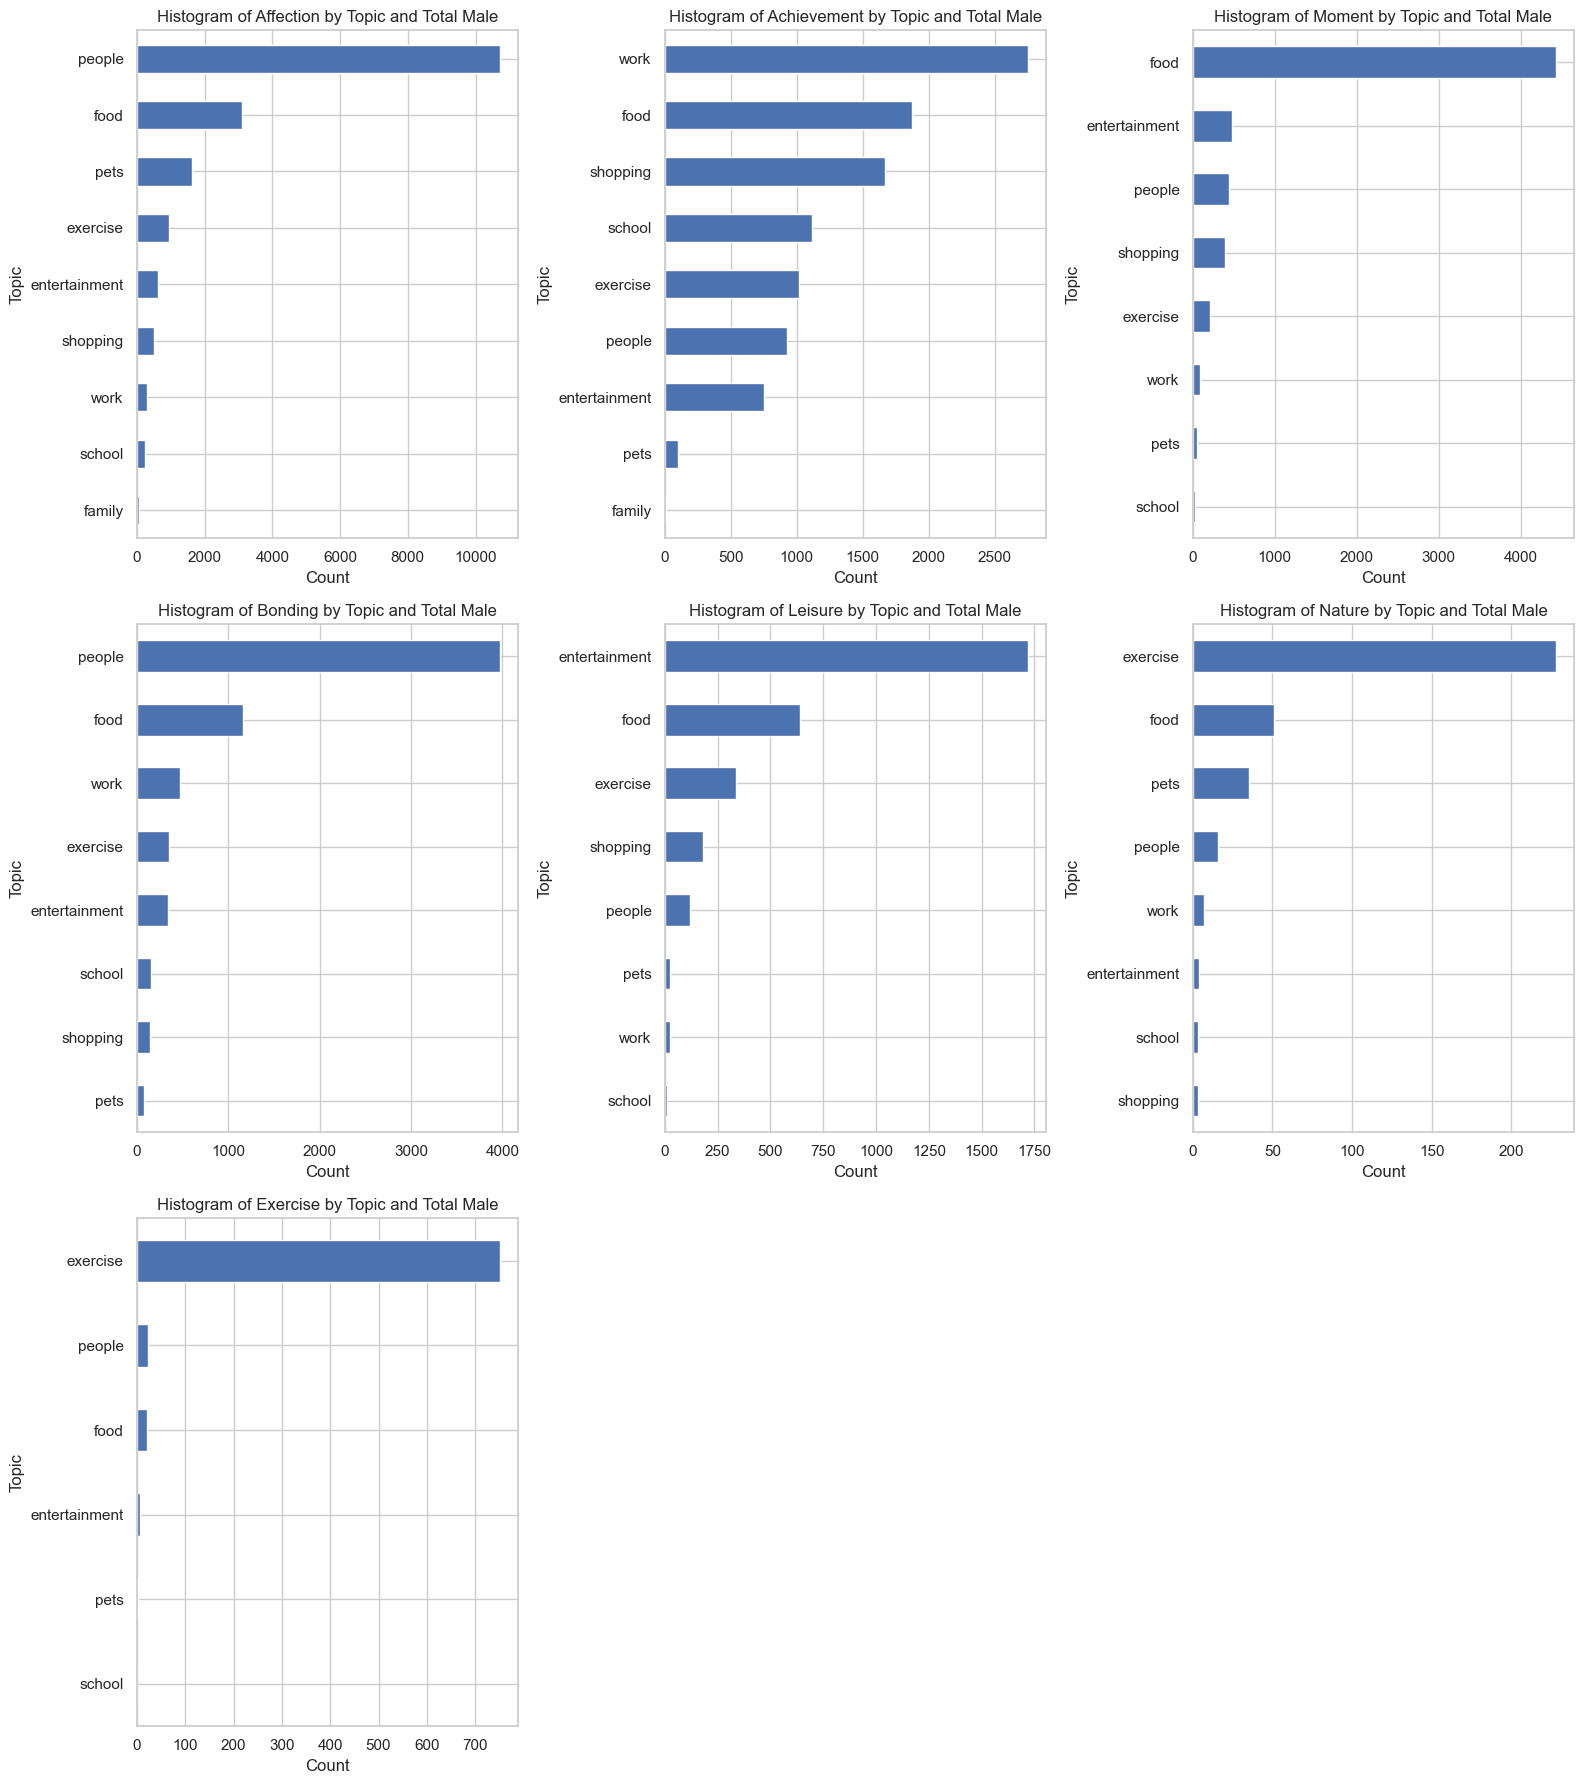

In [477]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 18))  # Adjusted for 4 rows and 2 columns

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Histogram for affection_cat
male_affection_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[0])
axes[0].set_title(f'Histogram of Affection by Topic and Total Male')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Topic')

# Histogram for achievement_cat
male_achievement_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[1])
axes[1].set_title(f'Histogram of Achievement by Topic and Total Male')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Topic')

# Histogram for moment_cat
male_moment_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[2])
axes[2].set_title(f'Histogram of Moment by Topic and Total Male')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Topic')

# Histogram for bonding_cat
male_bonding_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[3])
axes[3].set_title(f'Histogram of Bonding by Topic and Total Male')
axes[3].set_xlabel('Count')
axes[3].set_ylabel('Topic')

# Histogram for leisure_cat
male_leisure_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[4])
axes[4].set_title(f'Histogram of Leisure by Topic and Total Male')
axes[4].set_xlabel('Count')
axes[4].set_ylabel('Topic')

# Histogram for nature_cat
male_nature_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[5])
axes[5].set_title(f'Histogram of Nature by Topic and Total Male')
axes[5].set_xlabel('Count')
axes[5].set_ylabel('Topic')

# Histogram for exercise_cat
male_exercise_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[6])
axes[6].set_title(f'Histogram of Exercise by Topic and Total Male')
axes[6].set_xlabel('Count')
axes[6].set_ylabel('Topic')

# Hide the 8th subplot (which is empty)
axes[7].axis('off')
axes[8].axis('off')

# Adjust the layout so labels don't overlap
plt.tight_layout()
# Show the plot
plt.show()

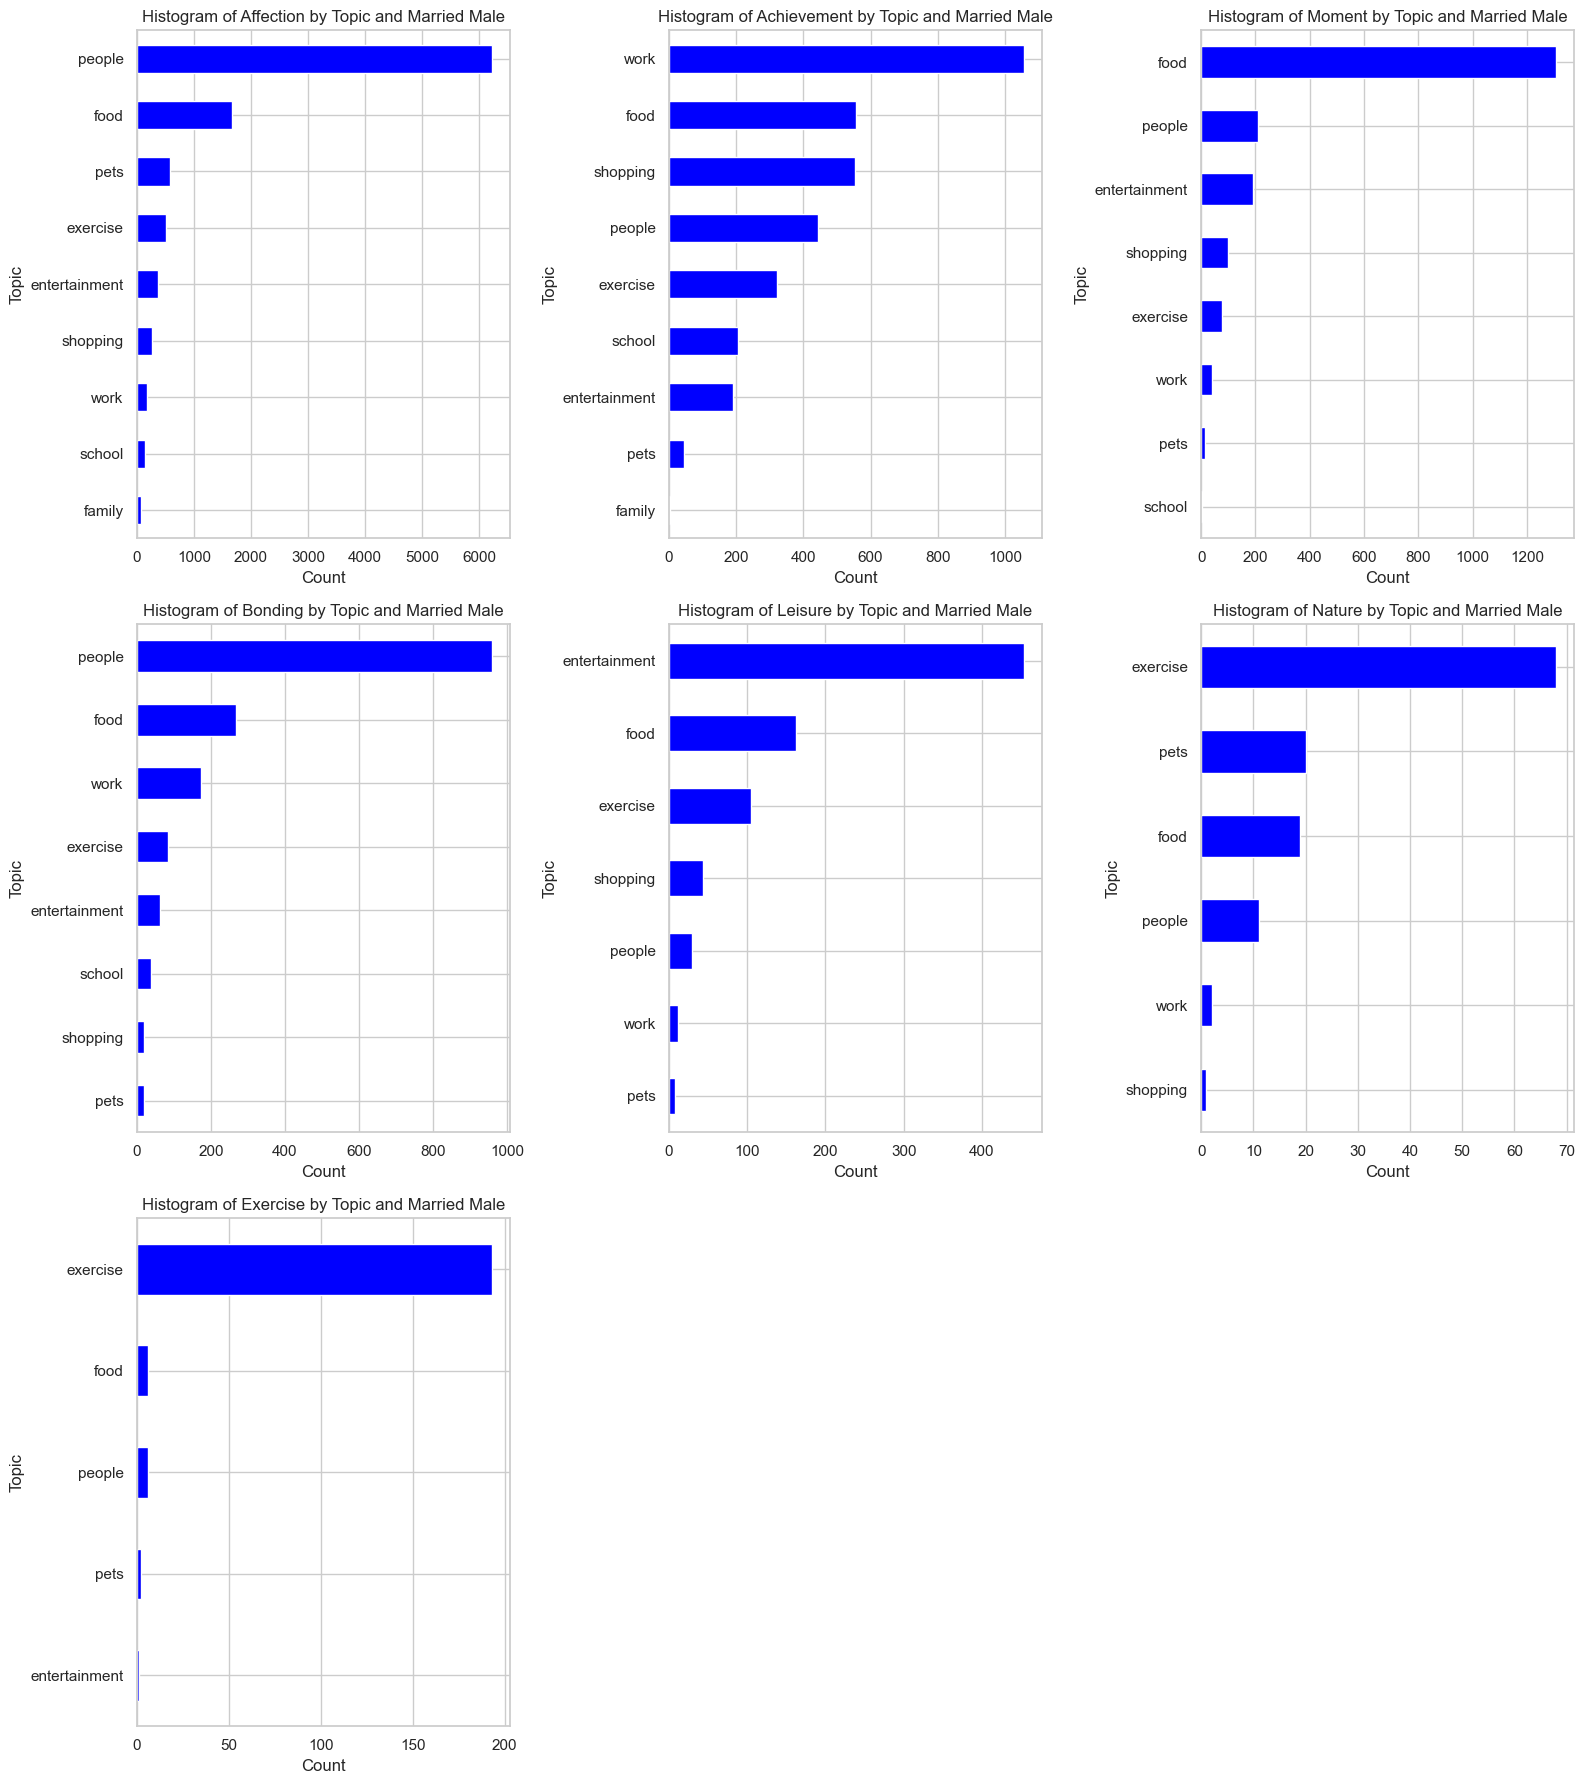

In [474]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 18))  # Adjusted for 4 rows and 2 columns

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Histogram for affection_cat
male_affection_married['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', color='blue',ax=axes[0])
axes[0].set_title(f'Histogram of Affection by Topic and Married Male')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Topic')

# Histogram for achievement_cat
male_achievement_married['topic'].value_counts().sort_values(ascending=True).plot(kind='barh',color='blue', ax=axes[1])
axes[1].set_title(f'Histogram of Achievement by Topic and Married Male')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Topic')

# Histogram for moment_cat
male_moment_married['topic'].value_counts().sort_values(ascending=True).plot(kind='barh',color='blue', ax=axes[2])
axes[2].set_title(f'Histogram of Moment by Topic and Married Male')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Topic')

# Histogram for bonding_cat
male_bonding_married['topic'].value_counts().sort_values(ascending=True).plot(kind='barh',color='blue', ax=axes[3])
axes[3].set_title(f'Histogram of Bonding by Topic and Married Male')
axes[3].set_xlabel('Count')
axes[3].set_ylabel('Topic')

# Histogram for leisure_cat
male_leisure_married['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', color='blue',ax=axes[4])
axes[4].set_title(f'Histogram of Leisure by Topic and Married Male')
axes[4].set_xlabel('Count')
axes[4].set_ylabel('Topic')

# Histogram for nature_cat
male_nature_married['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', color='blue',ax=axes[5])
axes[5].set_title(f'Histogram of Nature by Topic and Married Male')
axes[5].set_xlabel('Count')
axes[5].set_ylabel('Topic')

# Histogram for exercise_cat
male_exercise_married['topic'].value_counts().sort_values(ascending=True).plot(kind='barh',color='blue',ax=axes[6])
axes[6].set_title(f'Histogram of Exercise by Topic and Married Male')
axes[6].set_xlabel('Count')
axes[6].set_ylabel('Topic')

# Hide the 8th subplot (which is empty)
axes[7].axis('off')
axes[8].axis('off')

# Adjust the layout so labels don't overlap
plt.tight_layout()
# Show the plot
plt.show()


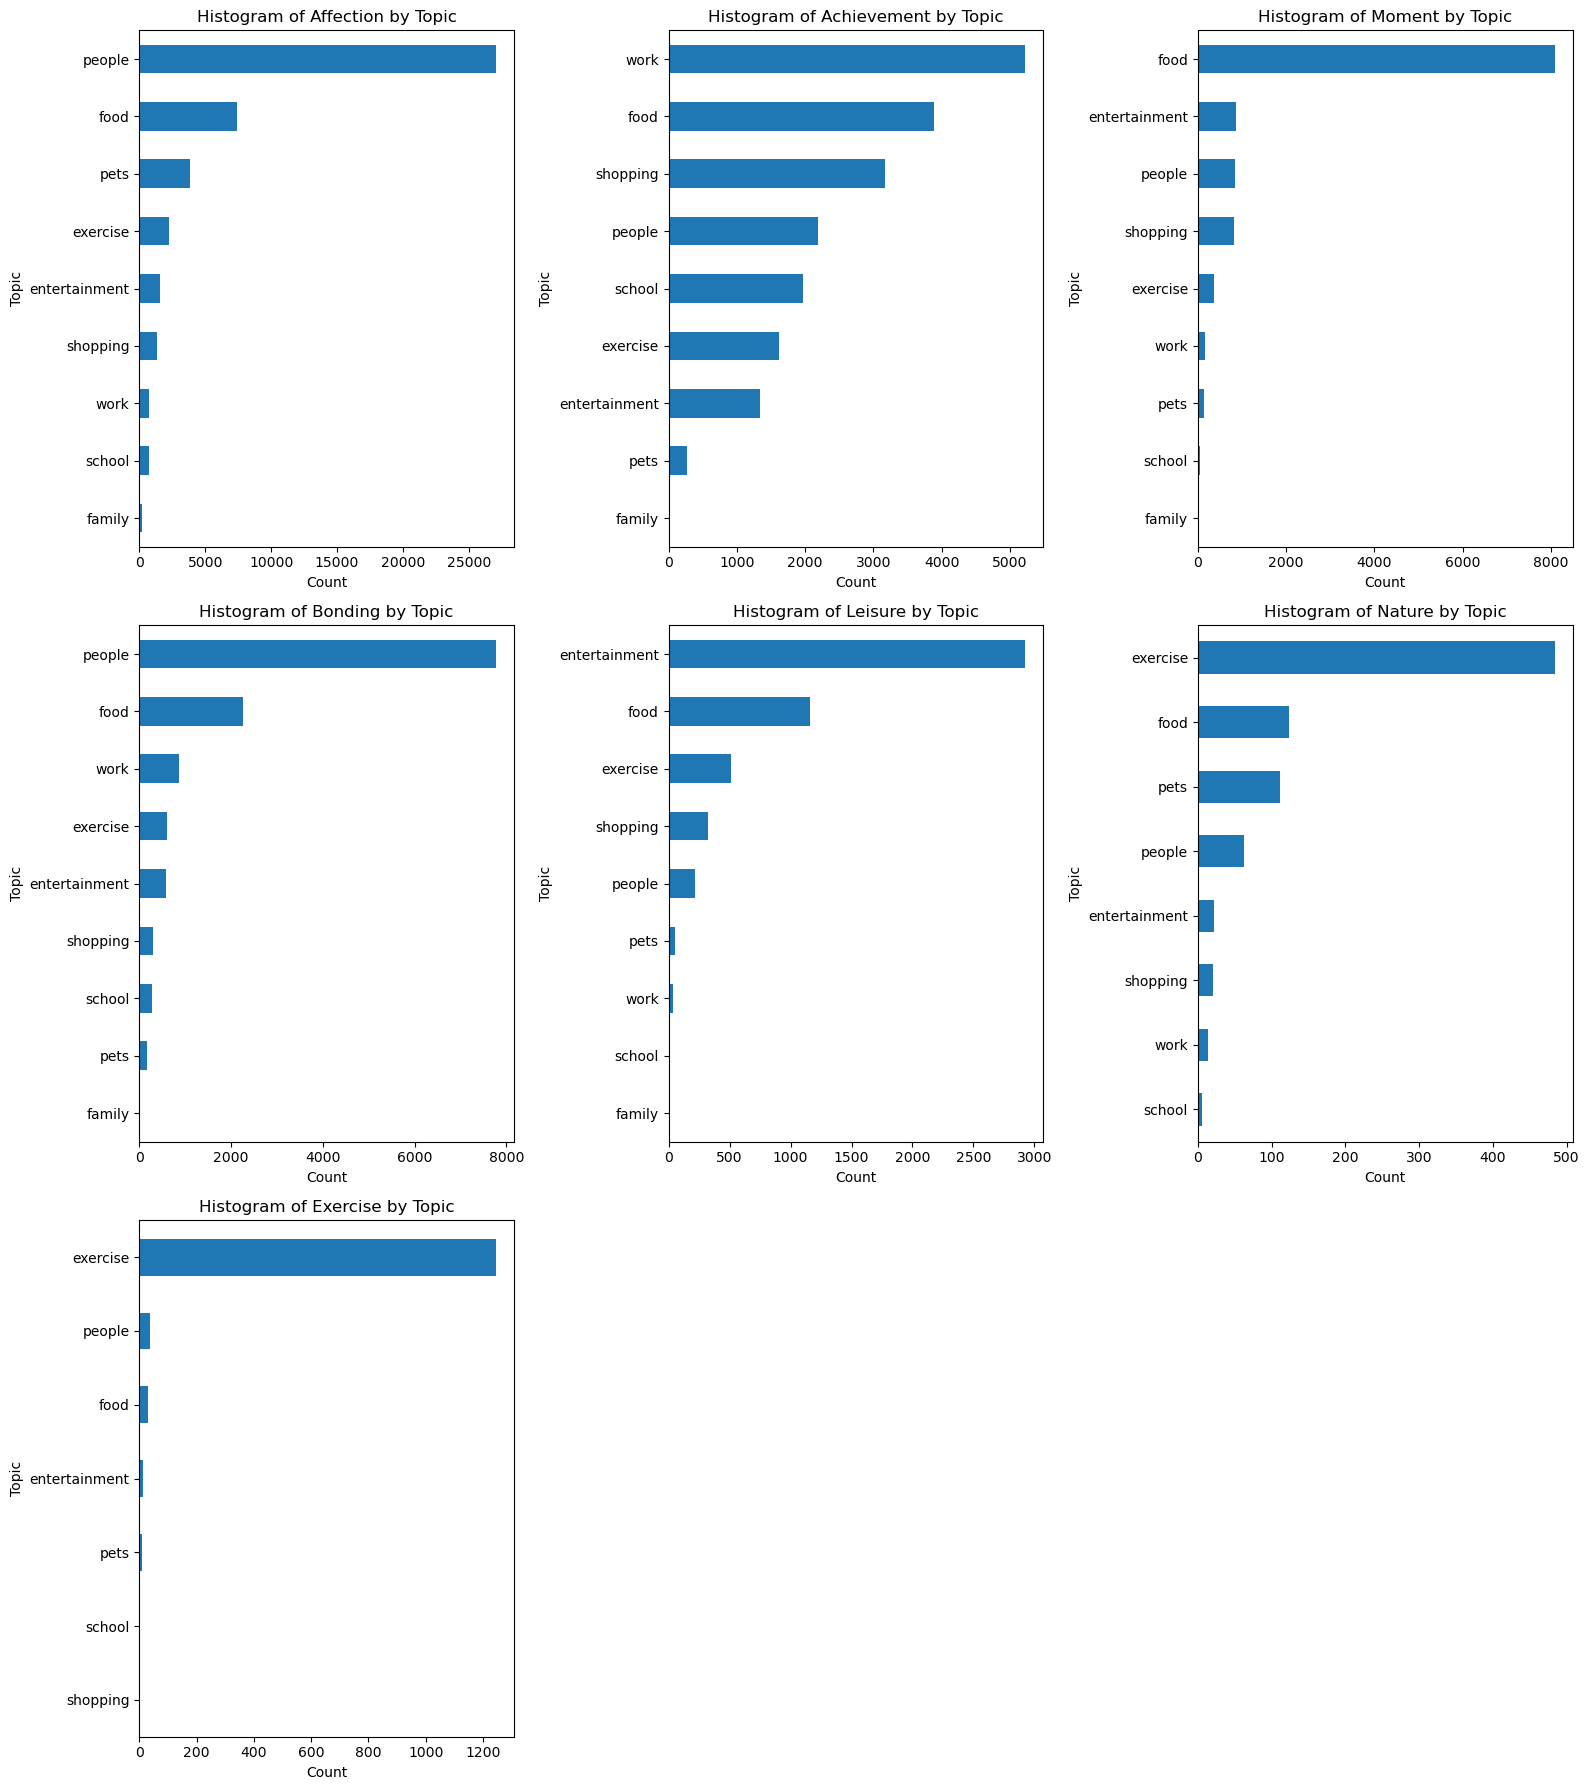

In [257]:
# Set up the figure for the plots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 18))  # Adjusted for 4 rows and 2 columns

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Histogram for affection_cat
affection_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[0])
axes[0].set_title(f'Histogram of Affection by Topic')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Topic')

# Histogram for achievement_cat
achievement_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[1])
axes[1].set_title(f'Histogram of Achievement by Topic')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Topic')

# Histogram for moment_cat
moment_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[2])
axes[2].set_title(f'Histogram of Moment by Topic')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Topic')

# Histogram for bonding_cat
bonding_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[3])
axes[3].set_title(f'Histogram of Bonding by Topic')
axes[3].set_xlabel('Count')
axes[3].set_ylabel('Topic')

# Histogram for leisure_cat
leisure_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[4])
axes[4].set_title(f'Histogram of Leisure by Topic')
axes[4].set_xlabel('Count')
axes[4].set_ylabel('Topic')

# Histogram for nature_cat
nature_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[5])
axes[5].set_title(f'Histogram of Nature by Topic')
axes[5].set_xlabel('Count')
axes[5].set_ylabel('Topic')

# Histogram for exercise_cat
exercise_cat['topic'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=axes[6])
axes[6].set_title(f'Histogram of Exercise by Topic')
axes[6].set_xlabel('Count')
axes[6].set_ylabel('Topic')

# Hide the 8th subplot (which is empty)
axes[7].axis('off')
axes[8].axis('off')

# Adjust the layout so labels don't overlap
plt.tight_layout()

# Show the plot
plt.show()


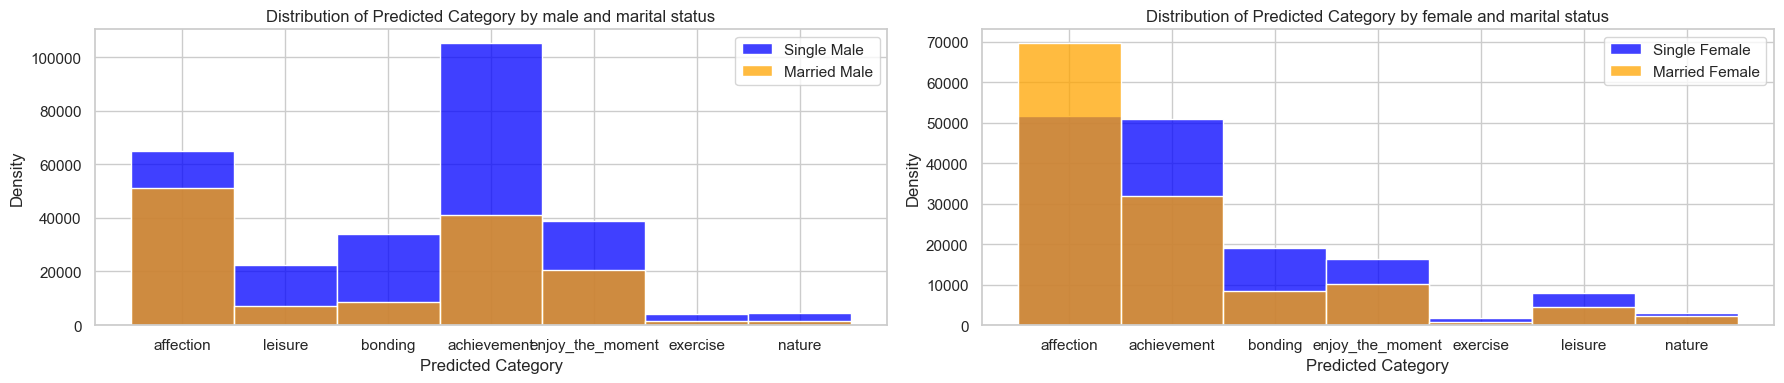

In [457]:
fig, axes = plt.subplots(1, 2, figsize=(18, 4))  # 1 row, 3 columns

# First plot on the first subplot (axes[0])
sns.histplot(male_single["predicted_category"], kde=False, bins=60, color="blue", label="Single Male", stat="count", ax=axes[0])
sns.histplot(male_married["predicted_category"], kde=False, bins=60, color="orange", label="Married Male", stat="count", ax=axes[0])
axes[0].set_xlabel("Predicted Category")
axes[0].set_ylabel("Density")
axes[0].set_title("Distribution of Predicted Category by male and marital status")
axes[0].legend()

# First plot on the first subplot (axes[0])
sns.histplot(female_single["predicted_category"], kde=False, bins=60, color="blue", label="Single Female", stat="count", ax=axes[1])
sns.histplot(female_married["predicted_category"], kde=False, bins=60, color="orange", label="Married Female", stat="count", ax=axes[1])
axes[1].set_xlabel("Predicted Category")
axes[1].set_ylabel("Density")
axes[1].set_title("Distribution of Predicted Category by female and marital status")
axes[1].legend()

plt.tight_layout()  # Adjust the layout so that all plots fit well
plt.show()

# Sentimental Analysis: VAD

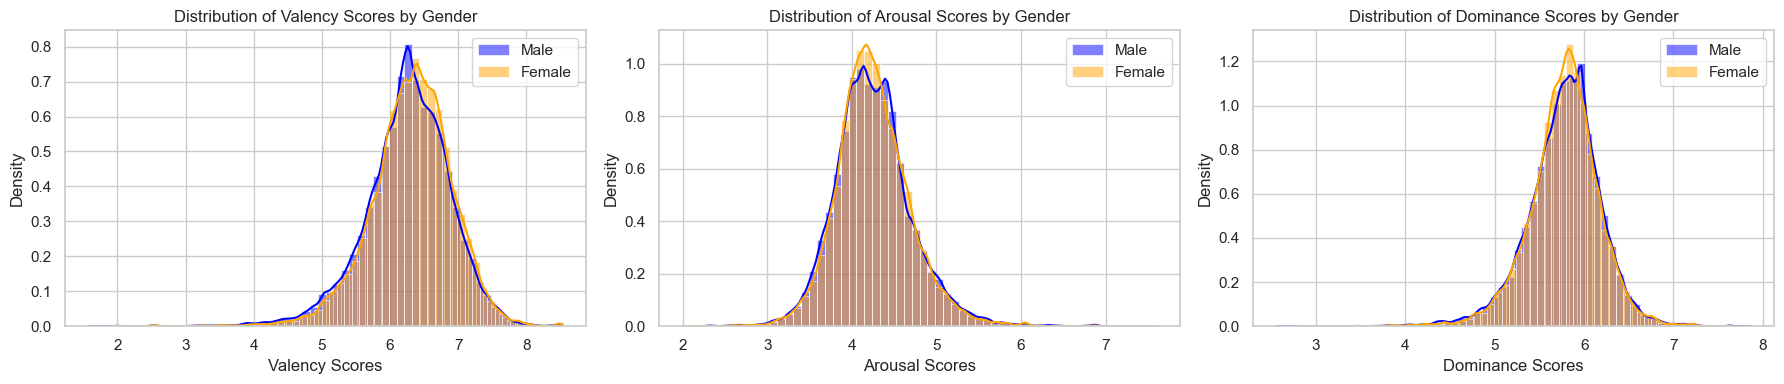

In [458]:
# by gender
fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # 1 row, 3 columns

# First plot on the first subplot (axes[0])
sns.histplot(total_male["valency"], kde=True, bins=60, color="blue", label="Male", stat="density", ax=axes[0])
sns.histplot(total_female["valency"], kde=True, bins=60, color="orange", label="Female", stat="density", ax=axes[0])
axes[0].set_xlabel("Valency Scores")
axes[0].set_ylabel("Density")
axes[0].set_title("Distribution of Valency Scores by Gender")
axes[0].legend()

# Second plot on the second subplot (axes[1])
sns.histplot(total_male["arousal"], kde=True, bins=60, color="blue", label="Male", stat="density", ax=axes[1])
sns.histplot(total_female["arousal"], kde=True, bins=60, color="orange", label="Female", stat="density", ax=axes[1])
axes[1].set_xlabel("Arousal Scores")
axes[1].set_ylabel("Density")
axes[1].set_title("Distribution of Arousal Scores by Gender")
axes[1].legend()

sns.histplot(total_male["dominance"], kde=True, bins=60, color="blue", label="Male", stat="density", ax=axes[2])
sns.histplot(total_female["dominance"], kde=True, bins=60, color="orange", label="Female", stat="density", ax=axes[2])
axes[2].set_xlabel("Dominance Scores")
axes[2].set_ylabel("Density")
axes[2].set_title("Distribution of Dominance Scores by Gender")
axes[2].legend()

plt.tight_layout()  # Adjust the layout so that all plots fit well
plt.show()

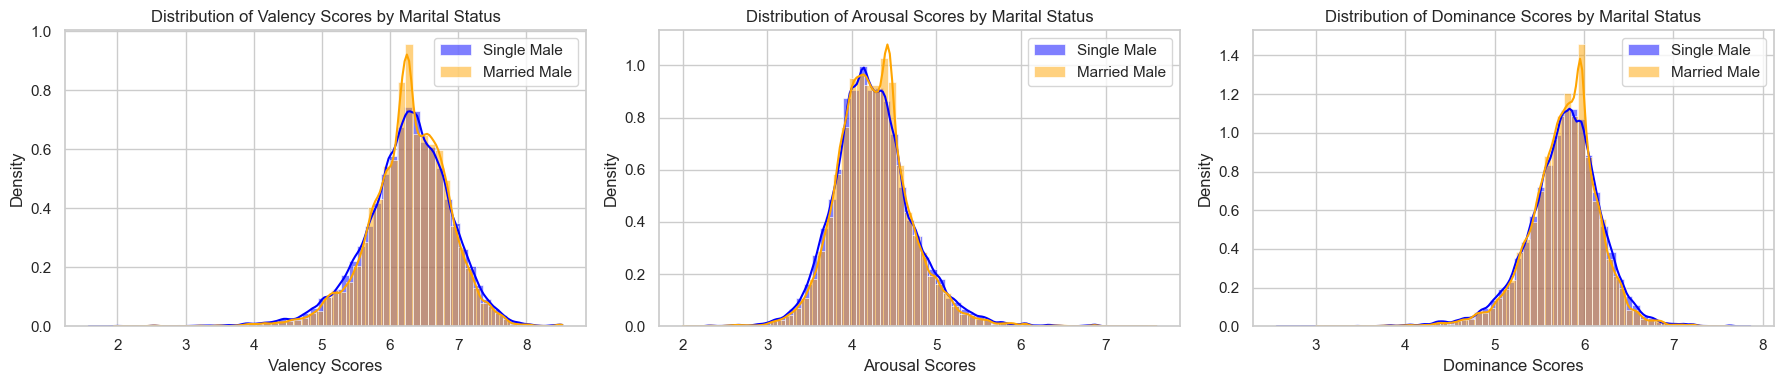

In [459]:
# by male and marital status
fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # 1 row, 3 columns

# First plot on the first subplot (axes[0])
sns.histplot(male_single["valency"], kde=True, bins=60, color="blue", label="Single Male", stat="density", ax=axes[0])
sns.histplot(male_married["valency"], kde=True, bins=60, color="orange", label="Married Male", stat="density", ax=axes[0])
axes[0].set_xlabel("Valency Scores")
axes[0].set_ylabel("Density")
axes[0].set_title("Distribution of Valency Scores by Marital Status")
axes[0].legend()

# Second plot on the second subplot (axes[1])
sns.histplot(male_single["arousal"], kde=True, bins=60, color="blue", label="Single Male", stat="density", ax=axes[1])
sns.histplot(male_married["arousal"], kde=True, bins=60, color="orange", label="Married Male", stat="density", ax=axes[1])
axes[1].set_xlabel("Arousal Scores")
axes[1].set_ylabel("Density")
axes[1].set_title("Distribution of Arousal Scores by Marital Status")
axes[1].legend()

sns.histplot(male_single["dominance"], kde=True, bins=60, color="blue", label="Single Male", stat="density", ax=axes[2])
sns.histplot(male_married["dominance"], kde=True, bins=60, color="orange", label="Married Male", stat="density", ax=axes[2])
axes[2].set_xlabel("Dominance Scores")
axes[2].set_ylabel("Density")
axes[2].set_title("Distribution of Dominance Scores by Marital Status")
axes[2].legend()

plt.tight_layout()  # Adjust the layout so that all plots fit well
plt.show()

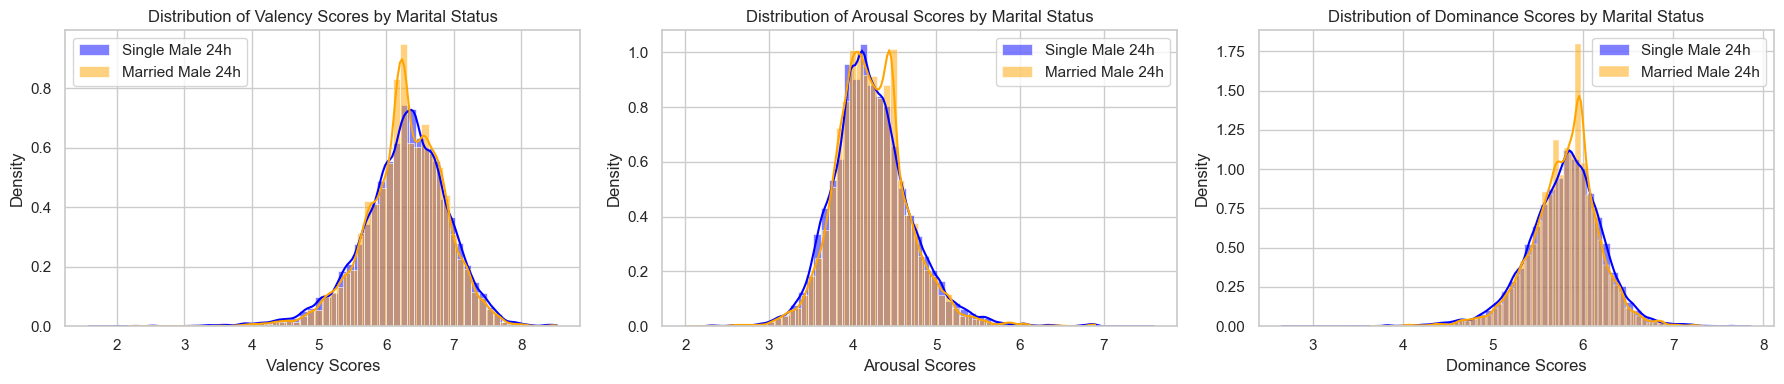

In [462]:
# by male, 24h, and marital status
fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # 1 row, 3 columns

# First plot on the first subplot (axes[0])
sns.histplot(male_single_24h["valency"], kde=True, bins=60, color="blue", label="Single Male 24h", stat="density", ax=axes[0])
sns.histplot(male_married_24h["valency"], kde=True, bins=60, color="orange", label="Married Male 24h", stat="density", ax=axes[0])
axes[0].set_xlabel("Valency Scores")
axes[0].set_ylabel("Density")
axes[0].set_title("Distribution of Valency Scores by Marital Status")
axes[0].legend()

# Second plot on the second subplot (axes[1])
sns.histplot(male_single_24h["arousal"], kde=True, bins=60, color="blue", label="Single Male 24h", stat="density", ax=axes[1])
sns.histplot(male_married_24h["arousal"], kde=True, bins=60, color="orange", label="Married Male 24h", stat="density", ax=axes[1])
axes[1].set_xlabel("Arousal Scores")
axes[1].set_ylabel("Density")
axes[1].set_title("Distribution of Arousal Scores by Marital Status")
axes[1].legend()

sns.histplot(male_single_24h["dominance"], kde=True, bins=60, color="blue", label="Single Male 24h", stat="density", ax=axes[2])
sns.histplot(male_married_24h["dominance"], kde=True, bins=60, color="orange", label="Married Male 24h", stat="density", ax=axes[2])
axes[2].set_xlabel("Dominance Scores")
axes[2].set_ylabel("Density")
axes[2].set_title("Distribution of Dominance Scores by Marital Status")
axes[2].legend()

plt.tight_layout()
plt.show()

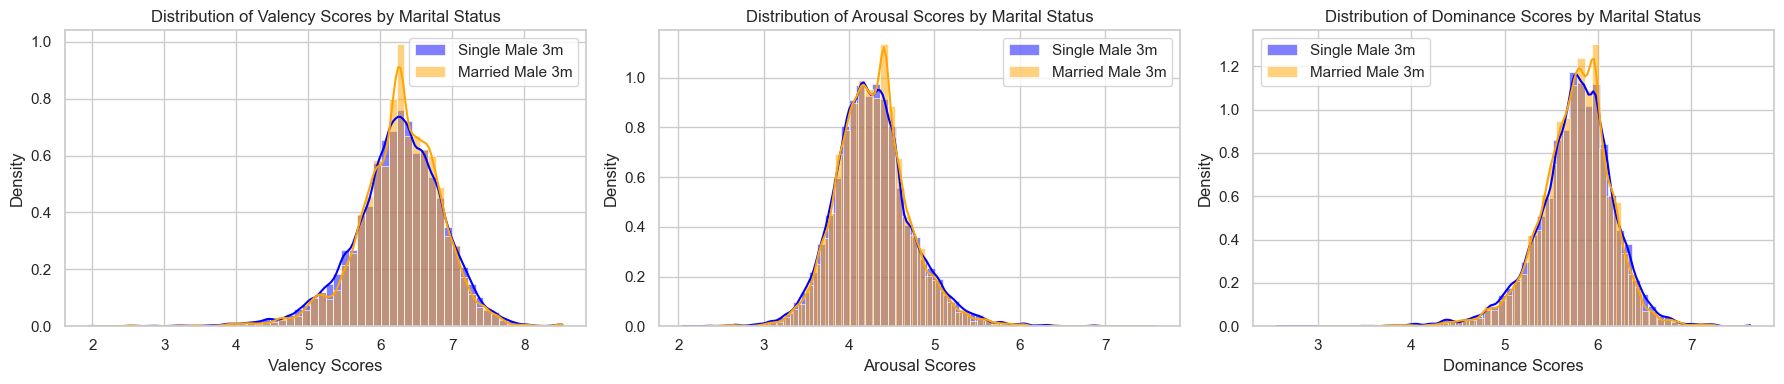

In [461]:
# by male, 3m, and marital status
fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # 1 row, 3 columns

# First plot on the first subplot (axes[0])
sns.histplot(male_single_3m["valency"], kde=True, bins=60, color="blue", label="Single Male 3m", stat="density", ax=axes[0])
sns.histplot(male_married_3m["valency"], kde=True, bins=60, color="orange", label="Married Male 3m", stat="density", ax=axes[0])
axes[0].set_xlabel("Valency Scores")
axes[0].set_ylabel("Density")
axes[0].set_title("Distribution of Valency Scores by Marital Status")
axes[0].legend()

# Second plot on the second subplot (axes[1])
sns.histplot(male_single_3m["arousal"], kde=True, bins=60, color="blue", label="Single Male 3m", stat="density", ax=axes[1])
sns.histplot(male_married_3m["arousal"], kde=True, bins=60, color="orange", label="Married Male 3m", stat="density", ax=axes[1])
axes[1].set_xlabel("Arousal Scores")
axes[1].set_ylabel("Density")
axes[1].set_title("Distribution of Arousal Scores by Marital Status")
axes[1].legend()

sns.histplot(male_single_3m["dominance"], kde=True, bins=60, color="blue", label="Single Male 3m", stat="density", ax=axes[2])
sns.histplot(male_married_3m["dominance"], kde=True, bins=60, color="orange", label="Married Male 3m", stat="density", ax=axes[2])
axes[2].set_xlabel("Dominance Scores")
axes[2].set_ylabel("Density")
axes[2].set_title("Distribution of Dominance Scores by Marital Status")
axes[2].legend()

plt.tight_layout()
plt.show()